<span style="color:Purple;font-size:45px;font-style:bold;">**Import Libraries**

In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape

import warnings
warnings.filterwarnings("ignore")

<span style="color:Purple;font-size:45px;font-style:bold;">**Load Data & Data Pre-Processing**

In [2]:
data = tf.keras.utils.image_dataset_from_directory(r"C:\Users\jbaby\documents\DLK\Fake_face\image_fake\img")

Found 2041 files belonging to 2 classes.


In [3]:
class_names = data.class_names
class_names

['fake', 'real']

In [4]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

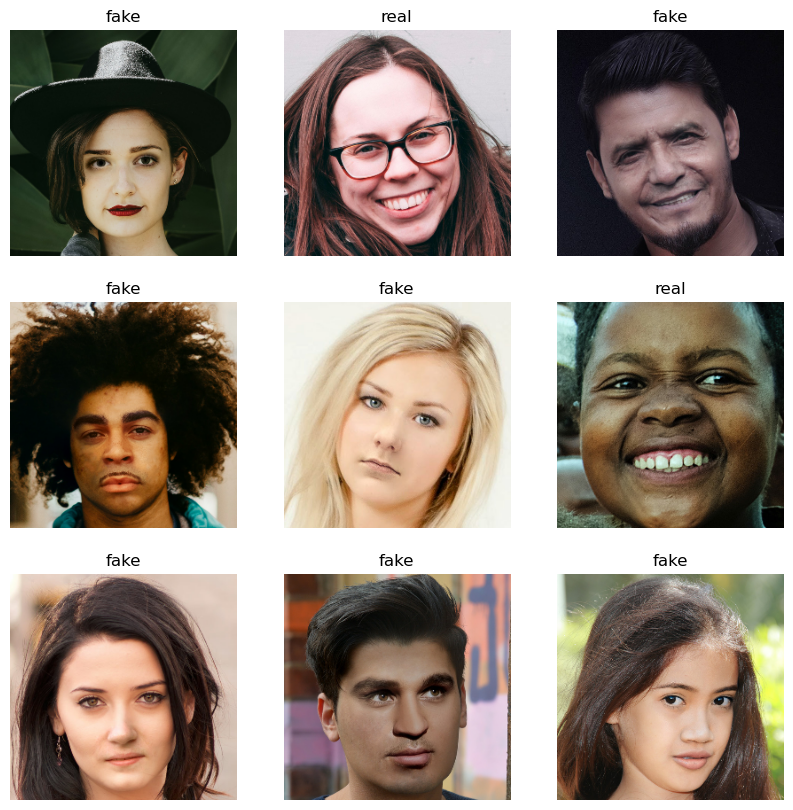

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [6]:
data = data.map(lambda x,y: (x/255, y)) # x/255
data.as_numpy_iterator().next()

(array([[[[0.43189722, 0.49464232, 0.49072075],
          [0.4379069 , 0.500652  , 0.49673042],
          [0.4404019 , 0.503147  , 0.49922544],
          ...,
          [0.47579658, 0.5385417 , 0.5346201 ],
          [0.4900314 , 0.5527765 , 0.54885495],
          [0.48852825, 0.55127335, 0.5473518 ]],
 
         [[0.43553826, 0.49828336, 0.4943618 ],
          [0.4429544 , 0.5056995 , 0.50177795],
          [0.44507122, 0.5078163 , 0.50389475],
          ...,
          [0.464299  , 0.52704406, 0.5231225 ],
          [0.4666102 , 0.5293553 , 0.5254337 ],
          [0.48088235, 0.54362744, 0.5397059 ]],
 
         [[0.4659371 , 0.52868223, 0.52476066],
          [0.43734297, 0.5000881 , 0.49616653],
          [0.43108246, 0.49382755, 0.48990598],
          ...,
          [0.50647885, 0.56922394, 0.5653024 ],
          [0.47750747, 0.54025257, 0.536331  ],
          [0.49053022, 0.5532753 , 0.5493537 ]],
 
         ...,
 
         [[0.45833907, 0.5210842 , 0.5171626 ],
          [0.43545

<span style="color:Purple;font-size:45px;font-style:bold;">**Data Pre - Training**

In [7]:
# # Load ResNet50 pre-trained on ImageNet without the top layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
data = tf.keras.utils.image_dataset_from_directory(r"C:\Users\jbaby\documents\DLK\Fake_face\image_fake\img")
class_names = data.class_names
data = data.map(lambda x,y: (x/255, y)) # Normalize images

train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)



Found 2041 files belonging to 2 classes.


In [8]:
# Extract features using ResNet50
def extract_resnet_features(dataset):
    resnet_features = []
    labels = []
    for images, labels_batch in dataset:
        features_batch = resnet_model.predict(images)
        # Reshape the features to collapse height and width dimensions
        features_batch = np.reshape(features_batch, (features_batch.shape[0], -1, features_batch.shape[3]))
        resnet_features.append(features_batch)
        labels.append(labels_batch)
    resnet_features = np.concatenate(resnet_features)
    labels = np.concatenate(labels)
    return resnet_features, labels

# Extract features and labels for train, validation, and test sets
train_resnet_features, train_labels = extract_resnet_features(train)
val_resnet_features, val_labels = extract_resnet_features(val)
test_resnet_features, test_labels = extract_resnet_features(test)

1/1 [==============================] - 2s 2s/step


<span style="color:Purple;font-size:45px;font-style:bold;">**Model Implementation**

In [9]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

loss = loss=tf.losses.BinaryCrossentropy()
model.compile(loss=loss, optimizer='adam',  metrics=["accuracy"])


In [10]:
lstm_model = Sequential([
    LSTM(256, input_shape=(train_resnet_features.shape[1], train_resnet_features.shape[2])),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

# Train LSTM model
lstm_hist = lstm_model.fit(train_resnet_features, train_labels, epochs=100, validation_data=(val_resnet_features, val_labels))

# Evaluate LSTM model on test data
loss_lstm, accuracy_lstm = lstm_model.evaluate(test_resnet_features, test_labels)
print("LSTM Loss: ", loss_lstm)
print("LSTM Accuracy: ", accuracy_lstm)


Epoch 1/100


44/44 [==============================] - 16s 275ms/step - loss: 0.7276 - accuracy: 0.5085 - val_loss: 0.6953 - val_accuracy: 0.4766
Epoch 2/100
44/44 [==============================] - 13s 293ms/step - loss: 0.6958 - accuracy: 0.5185 - val_loss: 0.6935 - val_accuracy: 0.5286
Epoch 3/100
44/44 [==============================] - 13s 290ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6906 - val_accuracy: 0.5260
Epoch 4/100
44/44 [==============================] - 12s 264ms/step - loss: 0.6900 - accuracy: 0.5412 - val_loss: 0.6881 - val_accuracy: 0.5391
Epoch 5/100
44/44 [==============================] - 12s 276ms/step - loss: 0.6883 - accuracy: 0.5469 - val_loss: 0.6879 - val_accuracy: 0.5339
Epoch 6/100
44/44 [==============================] - 12s 265ms/step - loss: 0.6911 - accuracy: 0.5376 - val_loss: 0.6903 - val_accuracy: 0.5026
Epoch 7/100
44/44 [==============================] - 12s 265ms/step - loss: 0.6890 - accuracy: 0.5320 - val_loss: 0.6875 - val_accurac

44/44 [==============================] - 13s 291ms/step - loss: 0.4742 - accuracy: 0.7557 - val_loss: 0.7602 - val_accuracy: 0.6354
Epoch 55/100
44/44 [==============================] - 13s 290ms/step - loss: 0.4664 - accuracy: 0.7642 - val_loss: 0.8499 - val_accuracy: 0.6094
Epoch 56/100
44/44 [==============================] - 13s 297ms/step - loss: 0.4427 - accuracy: 0.7983 - val_loss: 0.9027 - val_accuracy: 0.6458
Epoch 57/100
44/44 [==============================] - 13s 295ms/step - loss: 0.4696 - accuracy: 0.7642 - val_loss: 0.8816 - val_accuracy: 0.6562
Epoch 58/100
44/44 [==============================] - 13s 288ms/step - loss: 0.4620 - accuracy: 0.7763 - val_loss: 0.8738 - val_accuracy: 0.6094
Epoch 59/100
44/44 [==============================] - 13s 294ms/step - loss: 0.4705 - accuracy: 0.7713 - val_loss: 0.9244 - val_accuracy: 0.6562
Epoch 60/100
44/44 [==============================] - 13s 300ms/step - loss: 0.4457 - accuracy: 0.7855 - val_loss: 0.8088 - val_accuracy: 0.630

In [11]:
logdir='../logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

<span style="color:Purple;font-size:45px;font-style:bold;">**Model Summary**

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [13]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3
44/44 [==============================] - 19s 390ms/step - loss: 0.8605 - accuracy: 0.5369 - val_loss: 0.6921 - val_accuracy: 0.5234
Epoch 2/3
44/44 [==============================] - 17s 383ms/step - loss: 0.6910 - accuracy: 0.5604 - val_loss: 0.6876 - val_accuracy: 0.5130
Epoch 3/3
44/44 [==============================] - 17s 380ms/step - loss: 0.6617 - accuracy: 0.6165 - val_loss: 0.6713 - val_accuracy: 0.5885


<span style="color:Purple;font-size:45px;font-style:bold;">**Visualization**

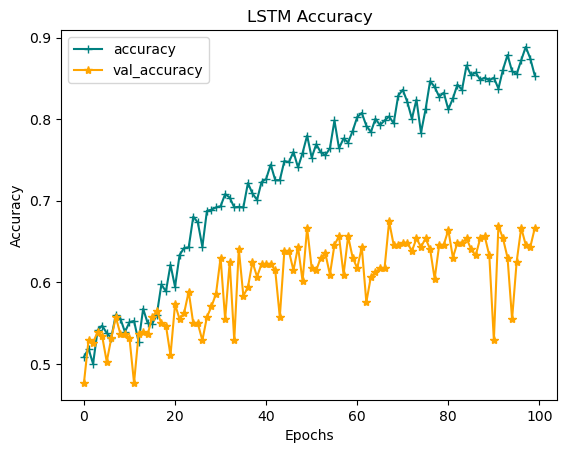

In [14]:
# Plot accuracy and loss for LSTM model
plt.figure()
plt.plot(lstm_hist.history['accuracy'], color='teal', label='accuracy',marker='+')
plt.plot(lstm_hist.history['val_accuracy'], color='orange', label='val_accuracy',marker='*')
plt.title('LSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

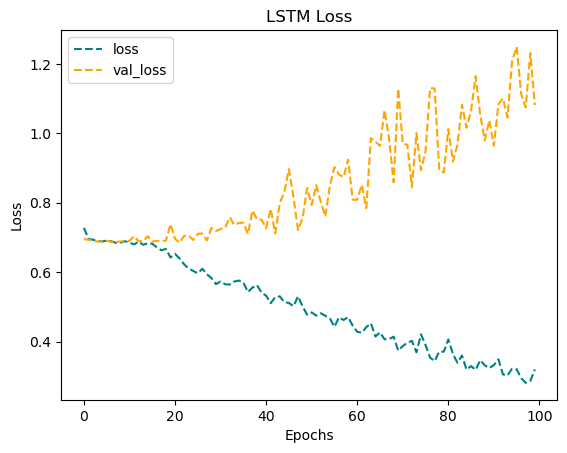

In [15]:
plt.figure()
plt.plot(lstm_hist.history['loss'], color='teal', linestyle='--',label='loss')
plt.plot(lstm_hist.history['val_loss'], color='orange', linestyle='--',label='val_loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


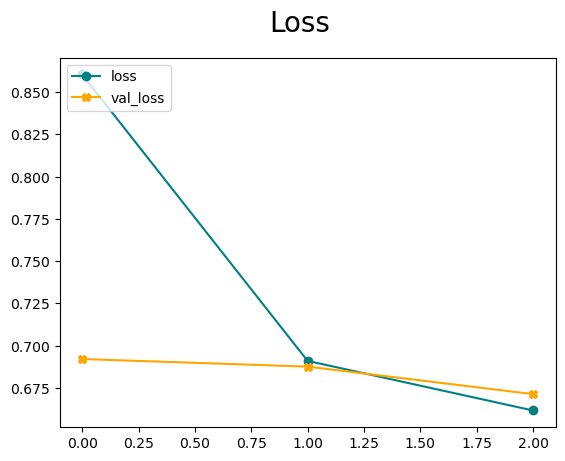

In [16]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss',marker='o')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss',marker='X')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

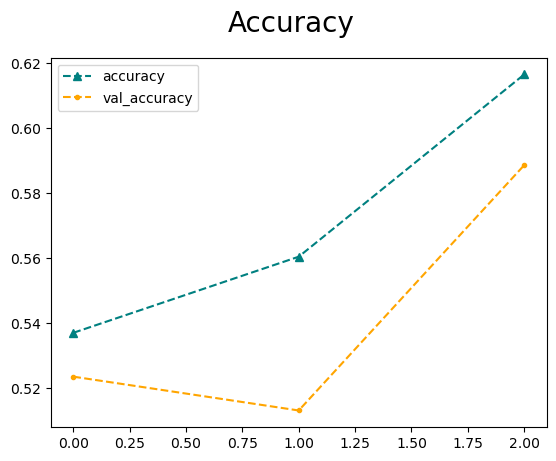

In [17]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', linestyle='--', label='accuracy',marker='^')
plt.plot(hist.history['val_accuracy'], color='orange', linestyle='--', label='val_accuracy',marker='.')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

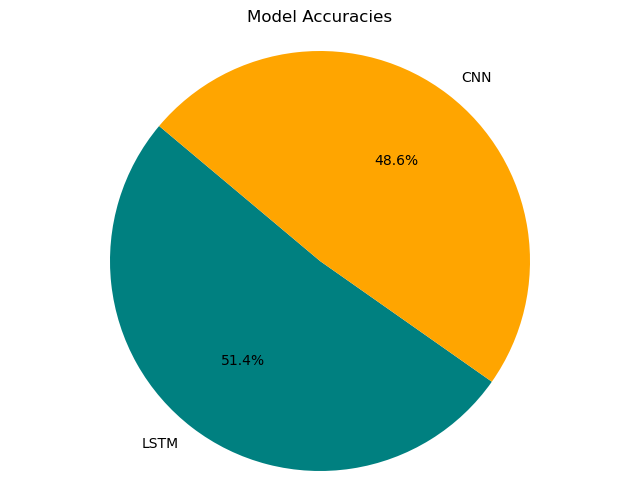

In [18]:
# Accuracy values obtained from model evaluations
accuracy_lstm = accuracy_lstm  # Replace with the actual accuracy of the LSTM model
accuracy_cnn = hist.history['accuracy'][-1]  # Extracting the final accuracy of the CNN model from its training history
# Labels for the pie chart
labels = ['LSTM', 'CNN']
# Accuracies for the pie chart
accuracies = [accuracy_lstm, accuracy_cnn]
# Colors for the pie chart
colors = ['teal', 'orange']
# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(accuracies, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Model Accuracies')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


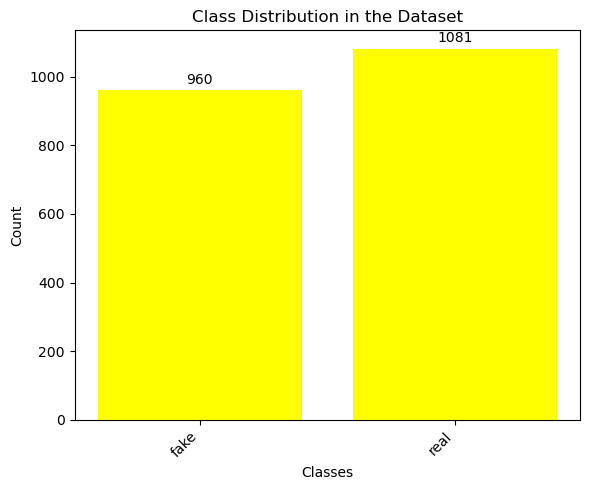

In [19]:
class_counts = {class_name: 0 for class_name in class_names}
for images, labels in data:
    for label in labels:
        class_counts[class_names[label]] += 1
# Extracting counts and class names
counts = list(class_counts.values())
class_names = list(class_counts.keys())
# Plotting the stacked bar chart
plt.figure(figsize=(6, 5))
plt.bar(class_names, counts, color='yellow', label='Count')
# Adding labels to each bar
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.title('Class Distribution in the Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


<span style="color:Purple;font-size:45px;font-style:bold;">**Model Standard**

In [20]:
loss, accuracy = model.evaluate(test)

6/6 [==============================] - 5s 61ms/step - loss: 0.6679 - accuracy: 0.6198


In [21]:
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Loss:  0.6678614616394043
Accuracy:  0.6197916865348816


In [22]:
# Define function to preprocess image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))  # Adjust target_size according to your model input shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizing the image data
    return img_array

# Provide the path to the image you want to predict
img_path = r"C:\Users\jbaby\documents\DLK\Fake_face\image_fake\img\real\real_00026.jpg" # Adjust the path to your image

# Preprocess the image
processed_img = preprocess_image(img_path)

# Make predictions
predictions = model.predict(processed_img)

# Print predictions
print(predictions)


1/1 [==============================] - 0s 168ms/step
[[0.54454845]]


Prediction: Real
[[0.54454845]]


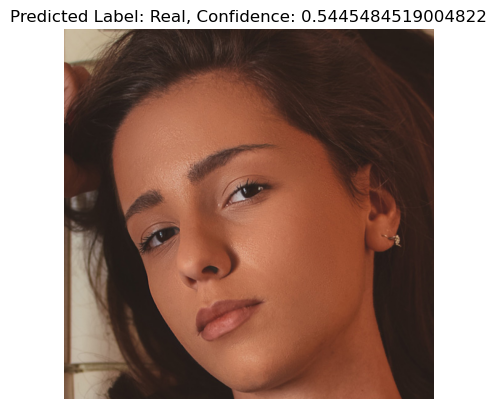

In [23]:
# Label the output
if predictions[0][0] <= 0.5:
    label = "Fake"
else:
    label = "Real"

# Print label
print("Prediction:", label)
print(predictions)
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted Label: {label}, Confidence: {predictions[0][0]}")
plt.axis('off')
plt.show()